In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_pickle('../cleaned_df.pkl')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378788 entries, 0 to 235628
Data columns (total 36 columns):
total_pymnt                   378788 non-null float64
zip_code                      378788 non-null category
member_id                     378788 non-null float64
id                            378788 non-null int64
loan_amnt                     378788 non-null float64
int_rate                      378788 non-null float64
installment                   378788 non-null float64
emp_length                    362383 non-null float64
home_ownership                378788 non-null category
grade                         378788 non-null category
sub_grade                     378788 non-null int64
emp_title                     355939 non-null object
issue_d                       378788 non-null datetime64[ns]
loan_status                   378788 non-null category
annual_inc                    378788 non-null float64
verification_status           378788 non-null category
purpose           

## Preparation

## Categorical variables

This data has a lot of categorical variables. I prefer `dmatrices` instead of `pd.get_dummies` as it is a lot cleaner.

In [3]:
from patsy import dmatrices

In [4]:
y, X = dmatrices('delinq ~  + loan_amnt + int_rate + installment + emp_length +'
                 'C(home_ownership) + C(grade) + C(month_issued) + C(year_issued)'
                 '+ C(purpose) + C(addr_state) + inq_last_6mths + pub_rec + revol_bal +open_acc+'
                 'collections_12_mths_ex_med + delinq_2yrs + earliest_cr_line  + fico_range_low'
                 '+ ratio_mth_inc_all_payments + annual_inc',
                 df, return_type='dataframe')

Earliest cr line to the year. Proabbly going to be quite good.

In [5]:
for i in X.columns[:10]:
    print(i,)

Intercept
C(home_ownership)[T.OTHER]
C(home_ownership)[T.OWN]
C(home_ownership)[T.RENT]
C(grade)[T.B]
C(grade)[T.C]
C(grade)[T.D]
C(grade)[T.E]
C(grade)[T.F]
C(grade)[T.G]


In [6]:
y = np.ravel(y)

Create a small testset for testing purposes

In [7]:
y_s, X_s = y[-10000:], X[-10000:]

## A first model: Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegressionCV

In [9]:
model_log = LogisticRegressionCV(cv=5, penalty='l2', verbose=1, max_iter=1000)

In [10]:
fit = model_log.fit(X_s, y_s)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [11]:
predictions = model_log.predict(X_s)

In [12]:
predictions.mean()

0.0

In [13]:
model_log.score(X_s, y_s)

0.91849999999999998

In [14]:
y_s.mean()

0.081500000000000003

## Train_test_split

In [5]:
from sklearn.cross_validation import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                   random_state=42)

## Using Class Weights

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
model_rf = RandomForestClassifier(n_estimators=200, oob_score=True, verbose=1, random_state=2143,
                                 min_samples_split=50, n_jobs=-2, class_weight='balanced')

In [12]:
rf_fit = model_rf.fit(X_train, y_train)

/Users/Will/anaconda/envs/py34/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:   51.1s finished


In [13]:
prediction = rf_fit.predict(X_test)

[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.7s finished


In [43]:
def generate_roc(X, y, model):
    """
    Takes a vector of features, X, a vector targets, y and draws an
    ROC along with AUC scores.

    :param X: numpy array (k x N) of features.
    :param y: numpy array (N x 1) of labels.
    :param model: an sklearn ALREADY FITTED classifer
    :return: draws a plot of ROC

    Notes
    ---
    - Meant to be run in pylab inline mode.
    - Only works with classification models.

    """
    y_pred = model.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc = roc_auc_score(y, y_pred)

    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, label='ROC Curve. AUC = {0:.2f}'.format(auc))

    # Plot our 45 degree line and make it a dashed dot
    plt.plot([0, 1], [0, 1], 'r--')

    # Axis work
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive (Delinquency) Rate')
    plt.ylabel('True Positive (Delinquency) Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

In [25]:
len(df.columns)

36

[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.6s finished


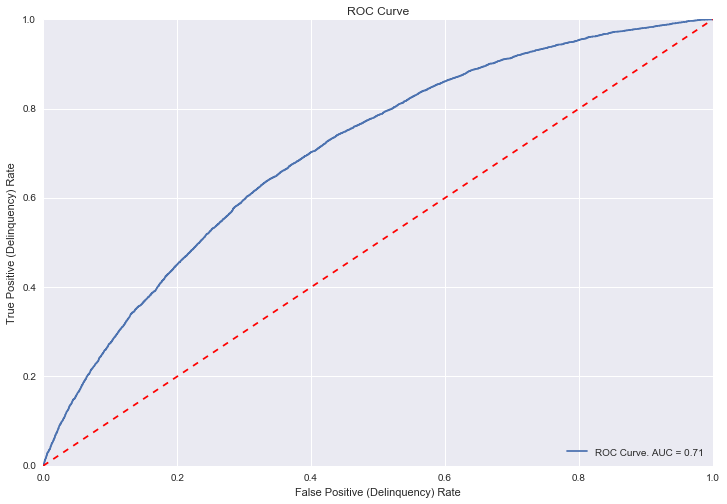

In [44]:
generate_roc(X_test, y_test, rf_fit)

In [38]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, [0,1], rotation=45)
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
prediction

array([ 1.,  1.,  1., ...,  1.,  1.,  0.])

In [34]:
c_matrix = confusion_matrix(y_test, prediction)

In [40]:
c_matrix

array([[44103,  4743],
       [ 4022,  1482]])

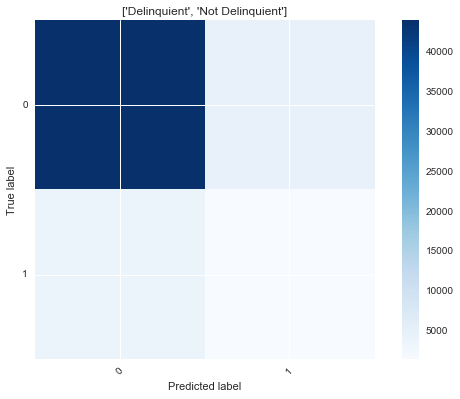

In [39]:
plot_confusion_matrix(c_matrix, ['Delinquient', 'Not Delinquient'])

In [ ]:
draw_confusion_matrices(confu)

In [20]:
prob_pred = rf_fit.predict_proba(X_test)

[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.6s finished


In [22]:
rf_fit.classes_

array([ 0.,  1.])

In [45]:
from sklearn.metrics import precision_score

In [46]:
precision = 1 - precision_score(y_test, prediction)

In [49]:
c_matrix

array([[44103,  4743],
       [ 4022,  1482]])

In [50]:
44103 / (44103 + 4743)

0.9028989067682103

Write precision formula here. 